&nbsp;

# 5. Regularization 
While training a machine learning model, the model can easily be overfitted or underfitted. 
To avoid this, we use regularization in machine learning to properly fit a model onto our test set. Overfitting occurs when the model learns too much detail and noise from the training data to the point when new data is exposed, the model will perform poorly on it. Regularization techniques help reduce the chance of overfitting by either adding penalties or stopping before the validation set's performance starts to decline. 

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# Importing our functions. 
import functions
import visuals

# Importing emsemble models. 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

# Import transformers. 
from sklearn.pipeline import Pipeline

# Renders plotly figs into svg static images. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train.csv".format(root)) # Importing the train set.
processed = pd.read_csv(r"{}\processed.csv".format(root)) # Importing the processed train dataset.
processed.head(2)

,car name_amc ambassador brougham,car name_amc ambassador dpl,car name_amc ambassador sst,car name_amc concord,car name_amc concord dl,car name_amc concord dl 6,car name_amc gremlin,car name_amc hornet,car name_amc hornet sportabout (sw),car name_amc matador,...,car name_vw rabbit,car name_vw rabbit c (diesel),cylinders,displacement,horsepower,weight,acceleration,model year,origin,mpg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,6.0,173.0,110.0,2725.0,12.6,81.0,1.0,23.5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8.0,400.0,170.0,4746.0,12.0,71.0,1.0,13.0


&nbsp;

### Section A: Regularization
This section will focus on enabling regularization techniques for all our chosen models to counter overfitting. 

**A.1: Check for Overfitting**<br>
Before we enable regularization it's a good idea to first check whether our models overfitted or not.

In [3]:
# Splitting the data. 
X = df.iloc[:,:-1] 
y = df.iloc[:,-1]

In [4]:
overfitGBR = functions.model_evaluation()
overfitGBR.preprocessing(df)
overfitGBR.add_pipe_component("clf", GradientBoostingRegressor(learning_rate=0.1, max_depth=50, min_samples_split=50, n_estimators=50))
pipe = Pipeline(steps=overfitGBR.estimators)
pipe = pipe.fit(X, y)
overfitGBR.overfitting_checker(X, y, pipe)

Model scored an Train_MSE_Score of: -0.51 and a Validation_MSE of: -9.09


In [5]:
overfitRFR = functions.model_evaluation()
overfitRFR.preprocessing(df)
overfitRFR.add_pipe_component("clf", RandomForestRegressor(max_depth=50, min_samples_split=2, min_samples_leaf=2, 
                                                           n_estimators=50))
pipe = Pipeline(steps=overfitRFR.estimators)
pipe = pipe.fit(X, y)
overfitRFR.overfitting_checker(X, y, pipe)

Model scored an Train_MSE_Score of: -2.23 and a Validation_MSE of: -8.97


In [6]:
overfitXGB = functions.model_evaluation()
overfitXGB.preprocessing(df)
overfitXGB.add_pipe_component("clf", XGBRegressor(learning_rate=0.1, max_depth=20, min_child_weight=15, n_estimators=250))
pipe = Pipeline(steps=overfitXGB.estimators)
pipe = pipe.fit(X, y)
overfitXGB.overfitting_checker(X, y, pipe)

Model scored an Train_MSE_Score of: -0.57 and a Validation_MSE of: -8.82


* It seems like for most models there is some degree of overfitting, so in the next section we'll enable regularization to punish mdoels that overfit.

| Model | Model Type | Train MSE | Validation MSE |
|---------|---------|---------|---------|
| **Gradient Boosting Regressor** |  Base Model | 0.51 |9.17 |
| **Random Forest Regressor** |  Base Model | 2.25 |9.11 |
| **XGB Regressor** |  Base Model | 0.57 |8.82 |

**A.3: Regularizing Gradient Boosting Regressor**<br>
To enable early stopping for our Gradient Boosting Regressor, we include the "n_iter_no_change" (early stopping), "validation_fraction" (validation set %) and "tol" (tolerance level) parameters.

In [7]:
testGBR, trainGBR, testTrainDifference = list(), list(), list()

# ML algorithms are stochastic in nature, so we'll evlauate our model through 10 iterations. 
for i in range(1,11): 
    # Check if the model overfit. 
    GBR = functions.model_evaluation()
    GBR.preprocessing(df)
    # Checking if our hypertuned models overfited.
    GBR.add_pipe_component("clf", GradientBoostingRegressor(learning_rate=0.1, max_depth=50, min_samples_split=50, n_estimators=50,
                                                            validation_fraction=0.2, n_iter_no_change=5, tol=1))
    pipe = Pipeline(steps=GBR.estimators)
    pipe = pipe.fit(X, y)
    GBR.overfitting_checker_no_print(X, y, pipe) 
    
    # Storing average results.  
    trainGBR.append(abs(GBR.results["train_score"].mean()))
    testGBR.append(abs(GBR.results["test_score"].mean()))
    testTrainDifference.append(round(abs(GBR.results["test_score"].mean()) - abs(GBR.results["train_score"].mean()),2))
    
print('Model scored an Train_MSE_Score of: %.2f and a Validation_MSE of: %.2f and the difference between the two is: %.2f' 
      % (np.mean(trainGBR), np.mean(testGBR), np.mean(testTrainDifference)))

Model scored an Train_MSE_Score of: 5.36 and a Validation_MSE of: 10.45 and the difference between the two is: 5.09


**A.4: Regularizing Random Forest Regressor**<br>
To regularize our Random Forest Regressor we increased our min_samples_split to 25.

In [8]:
testRFR, trainRFR, testTrainDifference = list(), list(), list()

# ML algorithms are stochastic in nature, so we'll evlauate our model through 10 iterations. 
for i in range(1,11): 
    # Check if the model overfit. 
    RFR = functions.model_evaluation()
    RFR.preprocessing(df)
    # Checking if our hypertuned models overfited.
    RFR.add_pipe_component("clf", RandomForestRegressor(max_depth=50, min_samples_split=25, min_samples_leaf=2, 
                                                               n_estimators=50))
    pipe = Pipeline(steps=RFR.estimators)
    pipe = pipe.fit(X, y)
    RFR.overfitting_checker_no_print(X, y, pipe) 

    # Storing average results.  
    trainRFR.append(abs(RFR.results["train_score"].mean()))
    testRFR.append(abs(RFR.results["test_score"].mean()))
    testTrainDifference.append(round(abs(RFR.results["test_score"].mean()) - abs(RFR.results["train_score"].mean()),2))
    
print('Model scored an Train_MSE_Score of: %.2f and a Validation_MSE of: %.2f and the difference between the two is: %.2f' 
      % (np.mean(trainRFR), np.mean(testRFR), np.mean(testTrainDifference)))

Model scored an Train_MSE_Score of: 6.66 and a Validation_MSE of: 10.59 and the difference between the two is: 3.93


| Model | Model Type | Regularization Metrics | MSE |
|---------|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model|validation_fraction=0.2, n_iter_no_change=5, tol=1 | 10.50 |
| **Random Forest Regressor** | Log Transformed | min_samples_split=25, max_depth=18 |10.54 |

**A.5: Regularizing XGB Regressor**<br>
To regularize our XGB Regressor we can implement the early stopping technique. This method involves the algorithm to stop training n number of epochs once the loss function of the validation set starts to deteroriate.

In [9]:
# Splitting the data. 
X = processed.iloc[:,:-1]
y = processed.iloc[:,-1]

In [10]:
# We'll set "n_estimators" to 500, to ensure the model has enough training time to overfit. 
XGBR = functions.Early_Stopping(X, y, XGBRegressor(eval_metric=["mae"], learning_rate=0.1, max_depth=20, 
                                                   min_child_weight=15, n_estimators=1000))

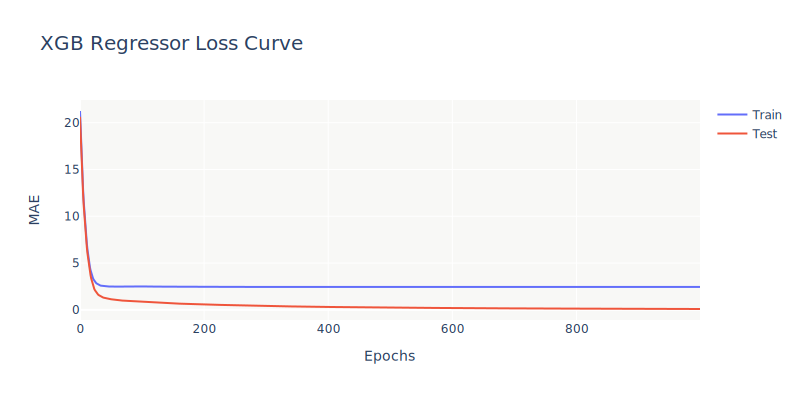

In [11]:
visuals.LogLoss_Curve(XGBR.x_axis, XGBR.results["validation_1"]['mae'], 
                        XGBR.results["validation_0"]['mae'])

In [12]:
# We'll set "n_estimators" to 500, to ensure the model has enough training time to overfit. 
earlyStoppingXGBR = functions.Early_Stopping(X, y, XGBRegressor(early_stopping_rounds=10, eval_metric=["mae"], 
                                                    learning_rate=0.1,max_depth=20, min_child_weight=15, n_estimators=250))

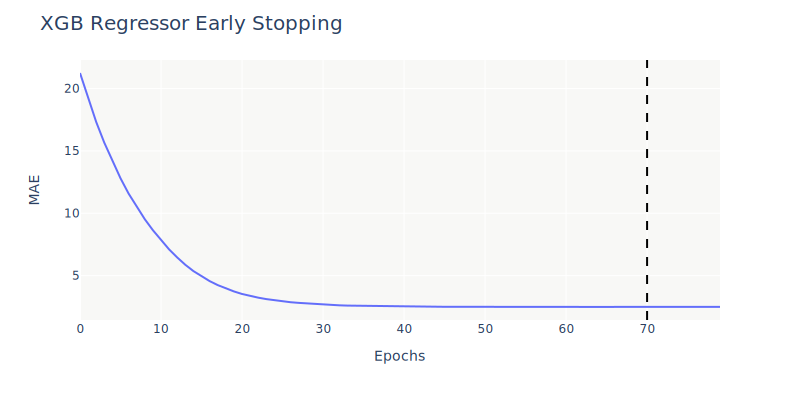

The model stopped training at around 80 epochs, with the best loss score observed at: 70.


In [13]:
# Plot early stopping results. 
fig = px.line(x=earlyStoppingXGBR.x_axis, y=earlyStoppingXGBR.results['validation_1']['mae'])
fig.add_vline(x=earlyStoppingXGBR.clf.best_ntree_limit, line_width=2, line_dash="dash", line_color="black") # Best loss score. 
fig.update_layout(title='XGB Regressor Early Stopping',
                       xaxis_title='Epochs',
                       yaxis_title='MAE',
                       height=400, width=800, plot_bgcolor='#F8F8F6', title_font_size=20, 
                       title_font_family='Arial Black')
fig.show()

print("The model stopped training at around 80 epochs, with the best loss score observed at: %.0f." % (
    earlyStoppingXGBR.clf.best_ntree_limit))
# Now we know that we should set our number of trees (n_estimator) to =70 to avoid overfitting.

**A.6: Conclusion**<br>
To sum up, we successfully regularized our regressor models through early stopping and managed to soften the impact of overfitting, whilst still retaining our strong validation performance. With all our models regularized and fitted with the best combination of hyperparameters it is now time to truely test our algorithms on the holdout dataset, that we put aside from the beginning of the project.

&nbsp;

| Model | Model Type | Regularized Hyperparameters | 
|---------|---------|---------|
| **Gradient Boosting Regressor** | Base Model   |learning_rate=0.1, max_depth=50, min_samples_split=50, n_estimators=50, <br>validation_fraction=0.2, n_iter_no_change=5, tol=1 | 
| **Random Forest Regressor** | Base Model |max_depth=50, min_samples_split=25, min_samples_leaf=2,  n_estimators=50 |
| **XGB Regressor** | Base Model | learning_rate=0.1, max_depth=20, min_child_weight=15, n_estimators=70 |

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  